In [1]:
# Ref: https://jaromiru.com/2016/10/03/lets-make-a-dqn-implementation/

# #--- enable this to run on GPU
# import os
# os.environ['THEANO_FLAGS'] = "device=cuda*,floatX=float32"  

import random, numpy, math, gym
from matplotlib import pyplot as plt


#-------------------- BRAIN ---------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
class DQN(nn.Module):

    def __init__(self, stateCnt, actionCnt):
        super(DQN, self).__init__()
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt
        self.fc1 = nn.Linear(in_features=stateCnt, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=actionCnt)

    def forward(self, x):
#         print(type(x))
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)
    

class Brain:

    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.model = self._createModel(stateCnt, actionCnt)
        # TODO: load model weights
        # ...
        
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=0.00025)
        self.criterion = nn.MSELoss()

    def _createModel(self, stateCnt, actionCnt):
        model = DQN(stateCnt, actionCnt)
        model.cuda()
        return model

    def train(self, x, y, epoch=1, verbose=0):
        x.cuda()
        y.cuda()
        self.model.train()
        self.optimizer.zero_grad()
        output = self.model(x)
        target = y
        loss = self.criterion(output, target)
        loss.backward()
        self.optimizer.step()

    def predict(self, s):
        self.model.eval()
        return self.model(s)

    def predictOne(self, s):
        self.model.eval()
        return self.model(s.reshape(1, self.stateCnt)).flatten()

#-------------------- MEMORY --------------------------
class Memory:   # stored as ( s, a, r, s_ )

    def __init__(self, capacity):
        self.samples = []
        self.capacity = capacity
        
    def __len__(self):
        return len(self.samples)

    def add(self, sample):
        self.samples.append(sample)        

        if len(self) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

#-------------------- AGENT ---------------------------
MEMORY_CAPACITY = 100000
BATCH_SIZE = 64

GAMMA = 0.99

MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.001      # speed of decay

class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self, stateCnt, actionCnt, exhibition_mode=False):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.brain = Brain(stateCnt, actionCnt)
        self.memory = Memory(MEMORY_CAPACITY)
        
        self.exhibition_mode = exhibition_mode
        
    def act(self, s):
        max_pred = torch.argmax(self.brain.predictOne(s)).long()
        # Always select the best action
        if self.exhibition_mode:
            return max_pred
        # Espsilon greedy
        if random.random() < self.epsilon:
            return torch.tensor(random.randint(0, self.actionCnt-1)).long()
        else:
            return max_pred

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)        

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return

#         print('Training ...')
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = torch.zeros(self.stateCnt)
        
#         print(type(batch[0]))
        states = torch.stack([ o[0] for o in batch ])
        states_ = torch.stack([ (no_state if o[3] is None else o[3]) for o in batch ])

        p = self.brain.predict( states )
        p_ = self.brain.predict( states_ )
        
#         print('p', p)
#         print('p_', p_)

        x = torch.zeros((batchLen, self.stateCnt))
        y = torch.zeros((batchLen, self.actionCnt))

        for i in torch.range(0, batchLen-1).long():
#             print(i)
            o = batch[i]
            s = o[0]; a = o[1]; r = o[2]; s_ = o[3]

            t = p[i]
#             print('a', a)
#             print('type(a)', type(a))
#             print('t', t)
#             print('t[a]', t[a])
            if s_ is None:
                t[a] = r
            else:
#                 print(t[a])
                t[a] = r + GAMMA * torch.argmax(p_[i])

            x[i] = s
            y[i] = t
#         print(type(x), type(y))
        self.brain.train(x, y)

#-------------------- ENVIRONMENT ---------------------
class Environment:
    def __init__(self, problem):
        self.problem = problem
        self.env = gym.make(problem)

    def run(self, agent):
        s = self.env.reset()
        s = torch.from_numpy(s).float()
        R = 0

        while True:         
#             self.env.render()

            a = int(agent.act(s))

            s_, r, done, info = self.env.step(a)
            r = torch.tensor(r)
            s_ = torch.from_numpy(s_).float()

            if done: # terminal state
                s_ = None

            # Observe and train, but don't if in exhibition mode
            if not agent.exhibition_mode:
                agent.observe( (s, a, r, s_) )
                agent.replay()

            s = s_
            R += r

            if done:
                break

        print("Total reward:", R)
        return R

#-------------------- MAIN ----------------------------

PROBLEM = 'CartPole-v0'
env = Environment(PROBLEM)

stateCnt  = env.env.observation_space.shape[0]
actionCnt = env.env.action_space.n

# Training mode
agent = Agent(stateCnt, actionCnt, exhibition_mode=False)

# # Exhibition mode
# agent = Agent(stateCnt, actionCnt, exhibition_mode=True)

episode_rewards = []

try:
    while True:
        R = env.run(agent)
        episode_rewards.append(R)
finally:
    if not agent.exhibition_mode:
        pass
        # TODO: save model weigths
        # ...


# #-------------------- SCRATCH ----------------------------
# # model = DQN(4, 2)
# # model(torch.ones((1, 4)))

# # brain = Brain(4, 2)
# # brain.train(torch.ones((1, 4)), torch.ones((1, 2)))
# # print(brain.predict(torch.ones((1, 4))))
# # print('max_pred', torch.argmax( brain.predict(torch.ones((1, 4)))) )
# # brain.predictOne(torch.ones((1, 4)))
# # print(brain.predict(torch.ones((10, 4))))

# agent = Agent(4, 2)
# print('action:', agent.act(torch.ones((1, 4))))
# # print(len(agent.memory))
# # agent.replay()
# # s = torch.ones((1, 4))
# # a = torch.ones((2)).long()
# # r = torch.ones((1))
# # s_ = torch.ones((1, 4))
# # sample = (s, a, r, s_)
# # sample1 = (s, a, r, s_)
# # sample2 = (s, a, r, s_)
# # print(torch.stack((s, s)))
# # for _ in range(64):  agent.memory.add(sample)
# # print(len(agent.memory))
# # agent.replay()
# PROBLEM = 'CartPole-v0'
# env = Environment(PROBLEM)
# env.env.reset()
# env.env.step(0)
# env.run(agent)


# agent = Agent(4, 2)
# print(agent.brain.predict(torch.ones((6, 4))))
# print(agent.brain.predictOne(torch.ones(1, 4)))
# print(agent.act(torch.ones((1, 4))))
# print(agent.brain.predict(torch.ones((6, 4)))[0])


AssertionError: 
The NVIDIA driver on your system is too old (found version 9010).
Please update your GPU driver by downloading and installing a new
version from the URL: http://www.nvidia.com/Download/index.aspx
Alternatively, go to: https://pytorch.org to install
a PyTorch version that has been compiled with your version
of the CUDA driver.

Text(0, 0.5, 'Episode reward')

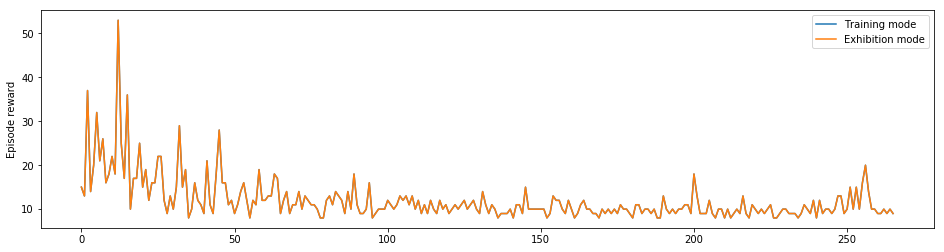

In [155]:
if not agent.exhibition_mode:
    naive_episode_rewards = episode_rewards[:]


fig, ax = plt.subplots()
fig.set_size_inches((16, 4))
ax.plot(naive_episode_rewards, label='Training mode')
ax.legend()

ax.plot(episode_rewards, label='Exhibition mode')
ax.legend()

ax.set_ylabel('Episode reward')